Here, we distill LaBSE for the Bashkir language. 

We completely update the vocabulary (because the original one doesn't contain Bashkir at all), and we make the model much shallower (only 3 layers instead of 12), but we preserve the dimensionality of LaBSE (768), so that it is easier to train the embedding in the same space. The model occupies 169MB on disk; most of this is the embedding layer. 

There are two training tasks: sentence embeddings (on a parallel corpus with Russian, with LaBSE as a teacher) and MLM (on a larger monolingual corpus). For MLM, multiple sentences are concatenated together into a sequence of 1024 tokens. 

The model relies on 3 sources of data:
* `../data/joint-ba-ru.tsv` - this is used for evaluation only, and can be ignored when reproducing 
* `AigizK/bashkir-russian-parallel-corpora` - a corpus of parallel bak-rus sentences
* `../../bashkort-spellchecker/data/clean_bk_sents.txt` - a corpus of sentences repacked from https://github.com/nevmenandr/bashkir-corpus

The model is trained for 100K steps, which takes about 25 hours on a GPU with 4GB of memory. After that, it gets:

* ROC AUC of 80%
* Recall @ idealistic of 48%

When training for 500k steps, it is slightly better:
* 0.8128387185291898
* recall@ ideal reject rate: 0.5658914728682171 th: 0.3692584551755409


# Load the data

In [1]:
import pandas as pd
import numpy as np
import torch

In [30]:
import gc
import numpy as np
import matplotlib.pyplot as plt

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [37]:
from transformers import BertForPreTraining, BertTokenizer, BertTokenizerFast, BertConfig, AutoModel, AutoTokenizer
# from transformers import AlbertTokenizerFast, AlbertConfig, AlbertForPreTraining

In [3]:
from tqdm.auto import tqdm, trange
import random

In [4]:
import datasets

In [7]:
labelled_data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')
labelled_data.shape

(176706, 5)

In [8]:
labelled_data.sample(3)

,date,ba,ru,is_correct,data_split
132046,11/02/2023 18:55:47,"— Һуң, шулай булмайса.","— Ну, да.",1,dev
15284,04/10/2021 08:24:29,"— Мәсьәлә хәҙер Сабирҙа тора, – тине апа, – ҡы...","— Теперь дело за Сабиром, – сказала апа, – есл...",1,train
28416,21/10/2021 05:17:19,"Бигүк вайымһыҙлыҡҡа бирелмәһә лә, Алдарбайҙа б...","Не предаваясь чересчур беспечности, все же про...",1,train


In [9]:
labelled_sents = set(labelled_data.ba)
print(len(labelled_sents))

157105


In [10]:
all_sents = []
with open('../../bashkort-spellchecker/data/clean_bk_sents.txt', 'r') as f:
    for line in tqdm(f):
        text = line.strip()
        if text not in labelled_sents:
            all_sents.append(text)

0it [00:00, ?it/s]

In [11]:
larger_parallel = datasets.load_dataset('AigizK/bashkir-russian-parallel-corpora')

Using custom data configuration AigizK--bashkir-russian-parallel-corpora-4908f7b0980c2b94
Found cached dataset parquet (C:/Users/david/.cache/huggingface/datasets/AigizK___parquet/AigizK--bashkir-russian-parallel-corpora-4908f7b0980c2b94/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
larger_parallel

DatasetDict({
    train: Dataset({
        features: ['ba', 'ru', 'corpus'],
        num_rows: 702100
    })
})

In [13]:
for text in tqdm(larger_parallel['train']['ba']):
    if text not in labelled_sents:
        all_sents.append(text)
print(len(all_sents))

  0%|          | 0/702100 [00:00<?, ?it/s]

2182945


In [33]:
all_pairs = []
for item in tqdm(larger_parallel['train']):
    if item['ba'] not in labelled_sents:
        all_pairs.append((item['ba'], item['ru']))
print(len(all_pairs))

  0%|          | 0/702100 [00:00<?, ?it/s]

580710


# Initialize tokenizer

In [5]:
old_tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
# old_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [6]:
2**15

32768

In [14]:
def batch_iterator(batch_size=10000):
    for i in tqdm(range(0, len(all_sents), batch_size)):
        yield all_sents[i : i + batch_size]

In [15]:
tokenizer = old_tokenizer.train_new_from_iterator(text_iterator=batch_iterator(), vocab_size=32768)

  0%|          | 0/219 [00:00<?, ?it/s]

In [16]:
len(tokenizer)

32768

In [17]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=32768, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [18]:
tokenizer('hello world')

{'input_ids': [2, 22407, 459, 19479, 91, 6608, 21473, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
for _ in range(10):
    print(tokenizer.tokenize(random.choice(all_sents)))

['Бөгөнгө', 'иҡтисади', 'шарттарҙы', 'иҫәпкә', 'алып', ',', 'үҙебеҙҙең', 'илдә', 'етештерелгән', 'технологик', 'линия', '##ны', 'һатып', 'алыу', 'күҙ', 'уңында', 'тотола', '.']
['Республика', 'башлығының', 'матбуғат', 'хеҙмәтенән', 'хәбәр', 'итеүҙәренсә', ',', 'Указға', 'ярашлы', ',', '2011', 'йылдың', '1', 'октябренән', 'мәктәпкәсә', 'йәштәге', 'балалар', 'менән', 'эшләгән', ',', 'төп', 'эш', 'урыны', 'буйынса', 'мәғариф', 'учреждениеларында', 'штат', '##та', 'торған', 'тәрбиәселәр', '##ҙең', ',', 'кесе', 'тәрбиәселәр', '##ҙең', ',', 'тәрбиәсе', 'ярҙамсылары', '##ның', ',', 'шулай', 'уҡ', 'мәктәпкәсә', 'йәштәге', 'балалар', 'менән', 'эшләгән', ',', 'төп', 'эш', 'урыны', 'буйынса', 'мәғариф', 'учреждениеларында', 'штат', '##та', 'торған', 'бер', 'һәм', 'ике', 'төркөм', '##лө', 'мәктәпкәсә', 'мәғариф', 'учреждениелары', 'мөдир', '##ҙәренең', 'эш', 'хаҡына', 'ай', 'һайын', 'түлә', '##не', '##үс', '##е', 'өҫтәмә', 'күләме', 'ике', 'тапҡырға', 'арттырылған', '.']
['Әлбиттә', ',', 'бының', 

In [88]:
length_ratios = []
lengths = []
for _ in trange(10000):
    s = random.choice(all_sents)
    tl = len(tokenizer.tokenize(s))
    length_ratios.append(len(s) / tl)
    lengths.append(tl)
    
pd.Series(length_ratios).describe()

  0%|          | 0/10000 [00:00<?, ?it/s]

count    10000.000000
mean         5.083908
std          1.181635
min          1.083333
25%          4.300000
50%          5.058824
75%          5.833333
max         11.000000
dtype: float64

In [89]:
pd.Series(lengths).describe()

count    10000.000000
mean        19.417700
std         15.216241
min          1.000000
25%         11.000000
50%         16.000000
75%         24.000000
max        320.000000
dtype: float64

In [90]:
pd.Series(lengths).quantile([0.9, 0.95, 0.99, 0.999])

0.900     34.000
0.950     43.000
0.990     71.000
0.999    160.003
dtype: float64

In [59]:
MEAN_TOKEN_LEN = 5

# Initialize the model

In [20]:
cfg = BertConfig(
    vocab_size=len(tokenizer),
    hidden_size=768,
    num_hidden_layers=3,
    num_attention_heads=12,
    intermediate_size=768 * 2,
    classifier_dropout=0.1,
    max_position_embeddings=2048, # because why not
)

In [21]:
tokenizer.model_max_length = cfg.max_position_embeddings

In [22]:
model = BertForPreTraining(cfg)

In [23]:
MODEL_SAVE_PATH = '../models/LaBSE-distilled-bak'

In [24]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../models/LaBSE-distilled-bak\\tokenizer_config.json',
 '../models/LaBSE-distilled-bak\\special_tokens_map.json',
 '../models/LaBSE-distilled-bak\\vocab.txt',
 '../models/LaBSE-distilled-bak\\added_tokens.json',
 '../models/LaBSE-distilled-bak\\tokenizer.json')

In [25]:
model

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 768, padding_idx=0)
      (position_embeddings): Embedding(2048, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

# Prepare the distillation

In [127]:
from transformers.optimization import Adafactor, AdamW
from transformers import DataCollatorForWholeWordMask
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

In [34]:
mname_teacher = 'cointegrated/LaBSE-en-ru'

In [38]:
teacher_tokenizer = AutoTokenizer.from_pretrained(mname_teacher)
teacher_model = AutoModel.from_pretrained(mname_teacher)

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
teacher_model.cuda()
model.cuda();

In [74]:
collator = DataCollatorForWholeWordMask(tokenizer, mlm=True, mlm_probability=0.3)

In [75]:
def get_acc2(e1, e2):
    batch_size = e1.shape[0]
    with torch.no_grad():
        scores = torch.matmul(e1, e2.T).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [76]:
# optimizer = Adafactor(
#     [p for p in model.parameters() if p.requires_grad], 
#     scale_parameter=False, relative_step=False, 
#     lr=1e-5, # make it very slow, because we want to update too many parameters
#     clip_threshold=1.0
# )

In [149]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],  
    lr=1e-4,
    weight_decay=1e-3,
)

In [150]:
loss_fn = torch.nn.CrossEntropyLoss()

In [151]:
losses2 = []
accuracies2 = []
losses_mlm = []

In [222]:
# I added these two trackers later
means_diag = []
accs_mlm = []

In [165]:
batch_size = 32 # we can get even more, but training gets slow
mlm_batch_size = 1
margin = 0.3
max_length = 128
max_length_mlm = 1024 # 2048 gives an error
training_steps = 100_000

In [153]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=5_000, num_training_steps=training_steps)

# Training loop

In [154]:
def get_batch_pairs(batch_size):
    return [list(p) for p in zip(*random.choices(all_pairs, k=batch_size))]

def get_batch_mono(batch_size, length_up_to=None):
    if not length_up_to:
        return random.choices(all_sents, k=batch_size)
    # concat multiple sentences to increase the length
    res = []
    while len(res) < batch_size:
        tmp, tmp_len = [], 0
        while tmp_len < length_up_to:
            s = random.choice(all_sents)
            tmp.append(s)
            tmp_len += len(s)
        res.append(' '.join(tmp))
    return res

In [155]:
get_batch_pairs(3)

[['Ауылға 20 б. 40-сы йй. аҙағында пионер лагеры урынында ҡасаба булараҡ нигеҙһалына.',
  'тупаҫ телле',
  'Уның эше элекке горизонталь тирмәндәрҙән айырыла.'],
 ['Основано в конце 40-х гг. 20 в. на месте пионерского лагеря как посёлоколо',
  'грубый',
  'Работа в ней отличается от ранее установленных горизонтальных мельниц.']]

In [156]:
get_batch_mono(2, 200)

['Республикала 2021 йылдың ноябрендә реаль иҫәпләнгән эш хаҡы 2020 йылдың ноябренә ҡарағанда 1,7 процентҡа артҡан. Ни сәбәптәндер ул юлы уға был награда бирелмәйсә ҡалды. Бындай күңелһеҙ хәлдәрҙе иҫкә төшөрөп торғо килмәй ҙә, тик тере хәтер ептәре өҙөлөп ҡалыу осрағы башҡаса юҡмы ни?',
 'Уның конс\xadтрукцияһына тартыу көсөн арттырыу\xadсы, һаҡсыллыҡты һәм эшләү ва\xadҡытын оҙайтыусы тех\xadно\xadлогиялар һа\xadлынды. Шайба гел яурын өҫтөнән осоп үтә. Ике быуаттан ашыу ваҡыт элек милләтебеҙ ирке, ер-һыуыбыҙ именлеге өсөн аяуһыҙ көрәшкән, иҫәпһеҙ-һанһыҙ ғәскәр туплап, батшаларҙың ҡотон алған, халҡы йөрәгенә азатлыҡ дәрте һалған данлы ҡаһарман, сәсән-шағир Салауат Юлаевтың кемлеген республикабыҙҙа барыһы ла яҡшы беләлер, тип уйлай инем бығаса.']

In [260]:
model.train()

tq = trange(len(losses2), training_steps)
for i in tq:
    xx, yy = get_batch_pairs(batch_size) #[list(p) for p in zip(*random.choices(all_pairs, k=batch_size))]
    sents = get_batch_mono(mlm_batch_size, MEAN_TOKEN_LEN * max_length_mlm) #random.choices(all_sents, k=mlm_batch_size)
    try:
        # translation ranking step step
        tm, tt = (teacher_model, teacher_tokenizer) # if random.random() < 0.8 else (model.bert, tokenizer)
        yy_batch = tt(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            yy_emb = torch.nn.functional.normalize(tm(**yy_batch.to(teacher_model.device)).pooler_output)

        xx_batch = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        xx_emb = torch.nn.functional.normalize(model.bert(**xx_batch.to(model.device)).pooler_output)
        all_scores = torch.matmul(yy_emb, xx_emb.T) - torch.eye(batch_size, device=model.device) * margin
        diag = torch.arange(batch_size, device=model.device)
        loss = loss_fn(all_scores, diag) + loss_fn(all_scores.T, diag)
        loss.backward()
        losses2.append(loss.item())
        accuracies2.append(get_acc2(xx_emb, yy_emb))
        means_diag.append(all_scores.diag().mean().item())

        # mlm step
        xx_batch = {k: v.to(model.device) for k, v in collator([
            tokenizer(s, truncation=True, max_length=max_length_mlm) 
            for s in sents
        ]).items()}
        mlm_logits = model(**xx_batch).prediction_logits.view(-1, model.config.vocab_size)
        loss = loss_fn(mlm_logits, xx_batch['labels'].view(-1))
        accs_mlm.append(
            ((mlm_logits.argmax(1) == xx_batch['labels'].view(-1)).sum() / (xx_batch['labels'] != -100).sum()).item()
        )
        loss.backward()
        losses_mlm.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss, xx_emb, yy_emb, mlm_logits = None, None, None, None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy))
        continue
    if i % 1000 == 0:
        print(i, np.mean(losses2[-1000:]), np.mean(accuracies2[-1000:]), np.mean(losses_mlm[-1000:]))
    if i % 10000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/15873 [00:00<?, ?it/s]

85000 6.225845907688141 0.99734375 6.917153728485108
86000 6.226040457248688 0.9974375 6.886059578418732
87000 6.223472689151764 0.99753125 6.866378093242646
88000 6.224348567008972 0.997546875 6.855117884635925
89000 6.226028457164764 0.997234375 6.853971759319306
90000 6.226158257484436 0.99765625 6.810354382038116
91000 6.2230573973655705 0.997703125 6.816799409389496
92000 6.223892151355743 0.997390625 6.809885332584381
93000 6.22495785856247 0.997953125 6.798032874107361
94000 6.224103188514709 0.99771875 6.776669689655304
95000 6.223587003707886 0.9975 6.782656890392303
96000 6.222969909191131 0.99746875 6.755901711940766
97000 6.22453830909729 0.99775 6.760703609466553
98000 6.223532780170441 0.99784375 6.745026287078858
99000 6.225041968345642 0.997515625 6.741124024868012


In [ ]:
###### batch, out, embeddings, all_scores, loss, xx_emb, ru_emb, yy_emb, mlm_logits = None, None, None, None, None, None, None, None, None
optimizer.zero_grad(set_to_none=True)
cleanup()

In [1]:
1

1

100000


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


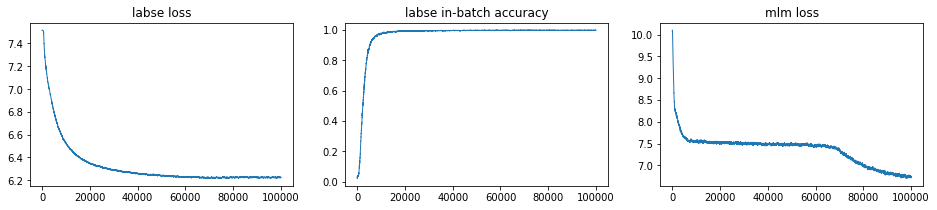

In [262]:
print(len(losses2))
plt.figure(figsize=(16, 3))
names = ['labse loss', 'labse in-batch accuracy', 'mlm loss']
for i, s in enumerate([losses2, accuracies2, losses_mlm]):
    plt.subplot(1, 3, i+1)
    pd.Series(s).ewm(100).mean()[10:].plot(lw=1)
    plt.title(names[i])

100000


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\pr

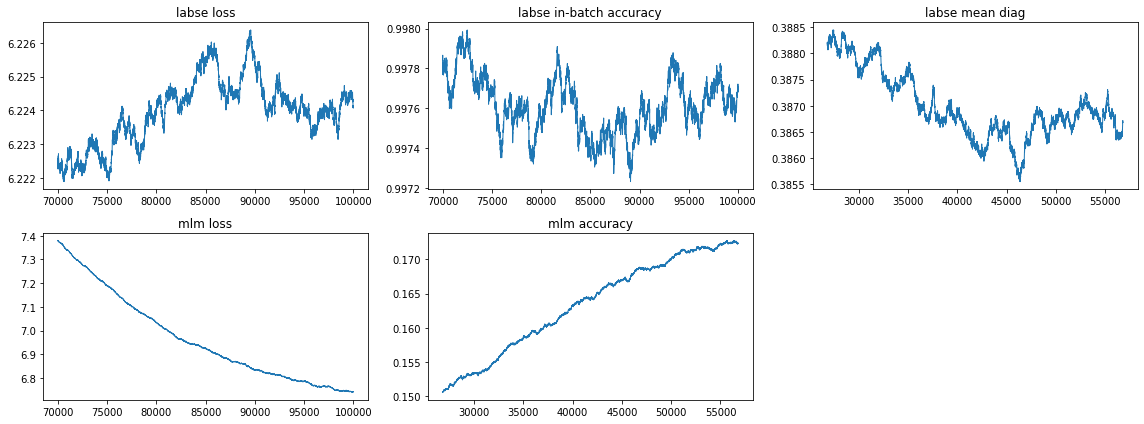

In [263]:
print(len(losses2))
plt.figure(figsize=(16, 6))
names = ['labse loss', 'labse in-batch accuracy', 'labse mean diag', 'mlm loss', 'mlm accuracy']
for i, s in enumerate([losses2, accuracies2, means_diag, losses_mlm, accs_mlm]):
    plt.subplot(2, 3, i+1)
    pd.Series(s).ewm(1300).mean()[-30000:].plot(lw=1)
    plt.title(names[i])
plt.tight_layout();

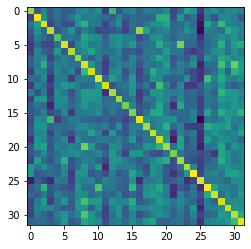

In [264]:
plt.imshow(all_scores.detach().cpu().numpy());

In [265]:
print(all_scores.diag().detach().cpu().numpy().mean())
print(all_scores.diag().detach().cpu().numpy())

0.40586135
[0.36101454 0.4714688  0.43977684 0.4100088  0.25973785 0.44853455
 0.3923145  0.3616308  0.44480777 0.42523402 0.45285666 0.42766446
 0.38701135 0.3743363  0.31779623 0.32873493 0.4561234  0.38169736
 0.41829443 0.42621112 0.3837273  0.31948555 0.37791324 0.38785273
 0.48081756 0.4438067  0.47848004 0.43237364 0.4291737  0.41394752
 0.40494847 0.4497822 ]


In [285]:
model.save_pretrained(MODEL_SAVE_PATH + '_100k')
tokenizer.save_pretrained(MODEL_SAVE_PATH + '_100k')

('../models/LaBSE-distilled-bak_100k\\tokenizer_config.json',
 '../models/LaBSE-distilled-bak_100k\\special_tokens_map.json',
 '../models/LaBSE-distilled-bak_100k\\vocab.txt',
 '../models/LaBSE-distilled-bak_100k\\added_tokens.json',
 '../models/LaBSE-distilled-bak_100k\\tokenizer.json')

# Evaluation

In [268]:
model.eval();

In [269]:
data_val = labelled_data[labelled_data.data_split=='val']

In [274]:
def embed(text, model, tokenizer, max_length=512):
    b = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.inference_mode():
        return torch.nn.functional.normalize(model(**b.to(model.device)).pooler_output).cpu().numpy()

In [276]:
embs_val_ru = np.concatenate([embed(t, teacher_model, teacher_tokenizer) for t in tqdm(data_val.ru)])

  0%|          | 0/1743 [00:00<?, ?it/s]

In [279]:
embs_val_ba = np.concatenate([embed(t, model.bert, tokenizer) for t in tqdm(data_val.ba)])

  0%|          | 0/1743 [00:00<?, ?it/s]

In [280]:
scores = (embs_val_ru * embs_val_ba).sum(1)
scores.shape

(1743,)

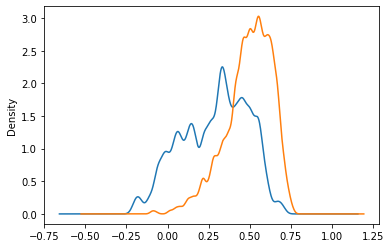

In [281]:
pd.Series(scores, index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [283]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(data_val.is_correct, scores))

0.798179018697644


In [284]:
threshold = np.quantile(scores, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (scores < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

recall@ ideal reject rate: 0.5348837209302325 th: 0.33203200500926544


# Continue fine-tuning the model, because it is too cool to give up

In [286]:
optimizer.param_groups[0]['lr']

1.368421052631579e-08

In [292]:
optimizer.param_groups[0]['lr'] = 1e-5

In [429]:
longer_training_steps = 500_000

In [396]:
LABSE_LOSS_WEIGHT = 1

In [482]:
model.train()

tq = trange(len(losses2), longer_training_steps)
for i in tq:
    xx, yy = get_batch_pairs(batch_size) #[list(p) for p in zip(*random.choices(all_pairs, k=batch_size))]
    sents = get_batch_mono(mlm_batch_size, MEAN_TOKEN_LEN * max_length_mlm) #random.choices(all_sents, k=mlm_batch_size)
    
    if len(losses2) >= 231892:
        LABSE_LOSS_WEIGHT = 3.0
    if len(losses2) >= 260292:
        optimizer.param_groups[0]['lr'] = 3e-5
    
    try:
        # translation ranking step step
        tm, tt = (teacher_model, teacher_tokenizer) # if random.random() < 0.8 else (model.bert, tokenizer)
        yy_batch = tt(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            yy_emb = torch.nn.functional.normalize(tm(**yy_batch.to(teacher_model.device)).pooler_output)

        xx_batch = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        xx_emb = torch.nn.functional.normalize(model.bert(**xx_batch.to(model.device)).pooler_output)
        all_scores = torch.matmul(yy_emb, xx_emb.T) - torch.eye(batch_size, device=model.device) * margin
        diag = torch.arange(batch_size, device=model.device)
        loss = loss_fn(all_scores, diag) + loss_fn(all_scores.T, diag)
        (loss * LABSE_LOSS_WEIGHT).backward()
        losses2.append(loss.item())
        accuracies2.append(get_acc2(xx_emb, yy_emb))
        means_diag.append(all_scores.diag().mean().item())

        # mlm step
        xx_batch = {k: v.to(model.device) for k, v in collator([
            tokenizer(s, truncation=True, max_length=max_length_mlm) 
            for s in sents
        ]).items()}
        mlm_logits = model(**xx_batch).prediction_logits.view(-1, model.config.vocab_size)
        loss = loss_fn(mlm_logits, xx_batch['labels'].view(-1))
        accs_mlm.append(
            ((mlm_logits.argmax(1) == xx_batch['labels'].view(-1)).sum() / (xx_batch['labels'] != -100).sum()).item()
        )
        loss.backward()
        losses_mlm.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        # scheduler.step() # now, no more scheduler, just train longer

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss, xx_emb, yy_emb, mlm_logits = None, None, None, None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy))
        continue
    if i % 1000 == 0:
        print(i, np.mean(losses2[-1000:]), np.mean(accuracies2[-1000:]), np.mean(losses_mlm[-1000:]))
    if i % 10000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/18759 [00:00<?, ?it/s]

482000 6.187337444782257 0.997859375 4.157376163721085
483000 6.187631000518799 0.998453125 4.151864949226379
484000 6.1863699593544 0.998453125 4.161313694477081
485000 6.1879832949638365 0.998453125 4.146268908262253
486000 6.188048386096955 0.99828125 4.1679085085392
487000 6.186364497184753 0.998578125 4.147880275249481
488000 6.1880199403762814 0.998359375 4.137477972269059
489000 6.186401232242584 0.99853125 4.135221461057663
490000 6.187198195934296 0.998421875 4.150099236011505
491000 6.185623805522919 0.998359375 4.134405615091324
492000 6.18808181476593 0.998796875 4.150139624118805
493000 6.185633585453034 0.99790625 4.13123006772995
494000 6.185075880527497 0.998296875 4.147060918331146
495000 6.186657132148743 0.9985 4.132001629590988
496000 6.185762422084808 0.998703125 4.1418153645992275
497000 6.18566955280304 0.998296875 4.107932206392288
498000 6.185416979789734 0.9985625 4.134957439899445
499000 6.187147036552429 0.99846875 4.130406265735626


* At 231892 steps I got tired of LaBSE loss not falling and increased its weigth x3

500000


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\pr

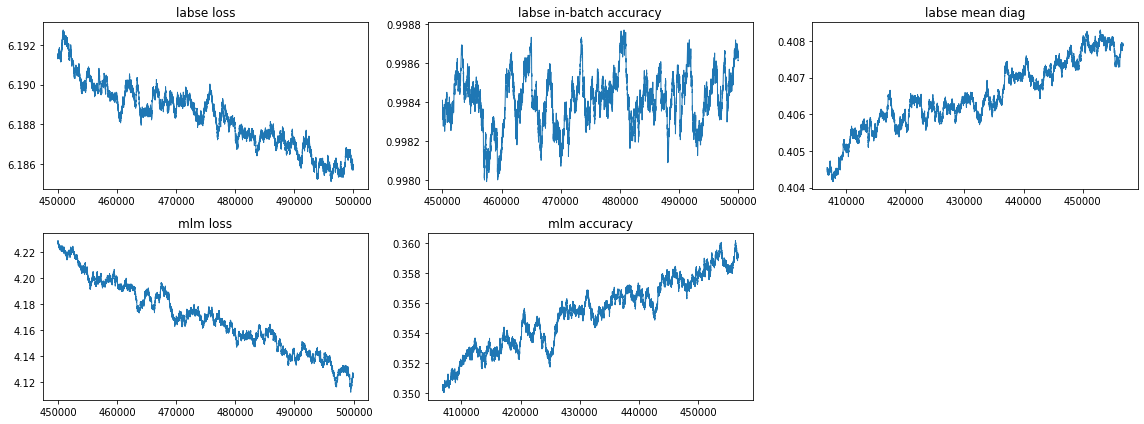

In [483]:
print(len(losses2))
plt.figure(figsize=(16, 6))
names = ['labse loss', 'labse in-batch accuracy', 'labse mean diag', 'mlm loss', 'mlm accuracy']
for i, s in enumerate([losses2, accuracies2, means_diag, losses_mlm, accs_mlm]):
    plt.subplot(2, 3, i+1)
    pd.Series(s).ewm(1000).mean()[-50_000:].plot(lw=1)
    plt.title(names[i])
plt.tight_layout();

500000


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\pr

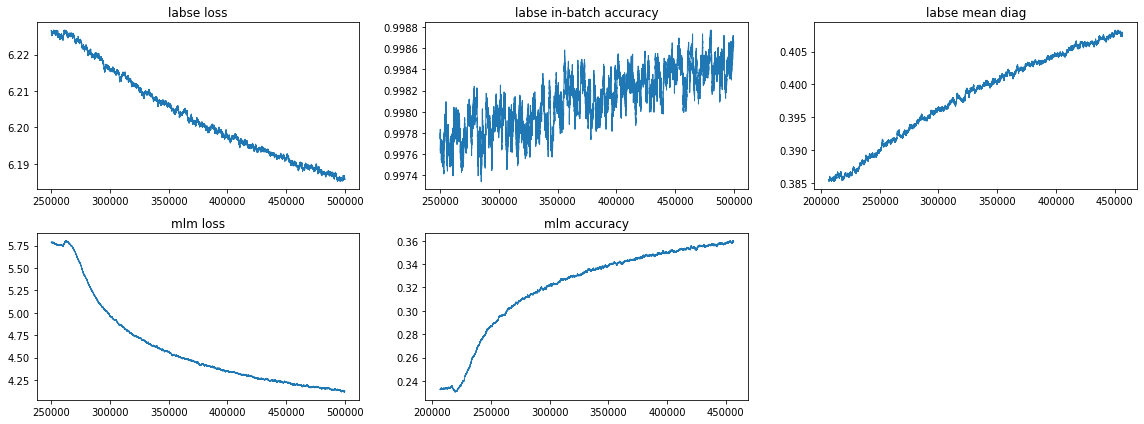

In [484]:
print(len(losses2))
plt.figure(figsize=(16, 6))
names = ['labse loss', 'labse in-batch accuracy', 'labse mean diag', 'mlm loss', 'mlm accuracy']
for i, s in enumerate([losses2, accuracies2, means_diag, losses_mlm, accs_mlm]):
    plt.subplot(2, 3, i+1)
    pd.Series(s).ewm(1000).mean()[-250_000:].plot(lw=1)
    plt.title(names[i])
plt.tight_layout();

500000


c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\users\david\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


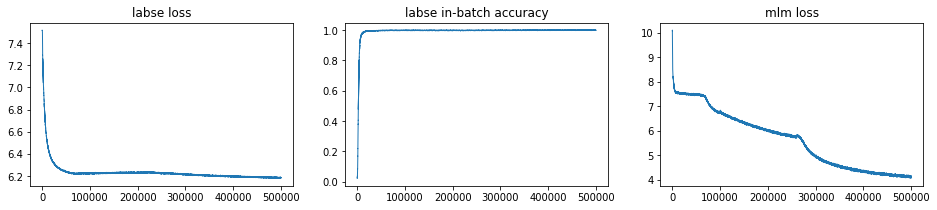

In [485]:
print(len(losses2))
plt.figure(figsize=(16, 3))
names = ['labse loss', 'labse in-batch accuracy', 'mlm loss']
for i, s in enumerate([losses2, accuracies2, losses_mlm]):
    plt.subplot(1, 3, i+1)
    pd.Series(s).ewm(100).mean()[10:].plot(lw=1)
    plt.title(names[i])

In [486]:
optimizer.param_groups[0]['lr']

3e-05

In [487]:
optimizer.zero_grad(set_to_none=True)
batch, out, embeddings, all_scores, loss, xx_emb, yy_emb, mlm_logits, diag = None, None, None, None, None, None, None, None, None
cleanup()

In [488]:
!nvidia-smi

Sun Mar 12 15:06:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   77C    P0    19W /  N/A |   2055MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [489]:
model.eval()
with torch.inference_mode():
    embs_val_ba = np.concatenate([embed(t, model.bert, tokenizer) for t in tqdm(data_val.ba)])

  0%|          | 0/1743 [00:00<?, ?it/s]

In [490]:
scores = (embs_val_ru * embs_val_ba).sum(1)
print(roc_auc_score(data_val.is_correct, scores))
threshold = np.quantile(scores, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (scores < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

0.8128387185291898
recall@ ideal reject rate: 0.5658914728682171 th: 0.3692584551755409


,count,mean,std,min,25%,50%,75%,max
is_correct,,,,,,,,
0,387.0,0.304949,0.209282,-0.183429,0.149433,0.327503,0.480308,0.712266
1,1356.0,0.528950,0.137435,-0.171754,0.455396,0.552306,0.631180,0.793831


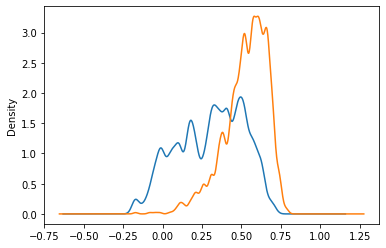

In [491]:
pd.Series(scores, index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
)
pd.Series(scores, index=data_val.index).groupby(data_val.is_correct).describe()

In [492]:
for k, v in list(globals().items()):
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

In [493]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../models/LaBSE-distilled-bak\\tokenizer_config.json',
 '../models/LaBSE-distilled-bak\\special_tokens_map.json',
 '../models/LaBSE-distilled-bak\\vocab.txt',
 '../models/LaBSE-distilled-bak\\added_tokens.json',
 '../models/LaBSE-distilled-bak\\tokenizer.json')